<a href="https://colab.research.google.com/github/UmaRani-Github/Colab_data/blob/main/Greenloan_Optuna_hypertuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna

In [ ]:
import pandas as pd
import time
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
# Load data
df = pd.read_csv("/content/loan_approval_balanced.csv")

# Encode categorical features
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != 'Loan_ID':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

In [ ]:
# Balance dataset
df_majority = df_encoded[df_encoded.Approval_Status == 0]
df_minority = df_encoded[df_encoded.Approval_Status == 1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
# Features & target
X = df_balanced.drop(columns=['Loan_ID', 'Approval_Status'])
y = df_balanced['Approval_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Results storage
results = []
roc_curves = []
pr_curves = []


In [ ]:
# Model tuning function
def tune_model(name):
    def objective(trial):
        if name == "LogisticRegression":
            C = trial.suggest_loguniform("C", 0.01, 10)
            solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
            model = LogisticRegression(C=C, solver=solver, max_iter=1000)
        elif name == "NaiveBayes":
            var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-9, 1e-7)
            model = GaussianNB(var_smoothing=var_smoothing)
        elif name == "KNeighbors":
            n_neighbors = trial.suggest_int("n_neighbors", 3, 7)
            weights = trial.suggest_categorical("weights", ["uniform", "distance"])
            metric = trial.suggest_categorical("metric", ["minkowski", "euclidean"])
            model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
        elif name == "XGBoost":
            n_estimators = trial.suggest_int("n_estimators", 50, 100)
            learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.1)
            max_depth = trial.suggest_int("max_depth", 3, 5)
            model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                  max_depth=max_depth, use_label_encoder=False,
                                  eval_metric='logloss', random_state=42)
        elif name == "RandomForest":
            n_estimators = trial.suggest_int("n_estimators", 50, 100)
            max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
            min_samples_split = trial.suggest_int("min_samples_split", 2, 5)
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                           min_samples_split=min_samples_split, random_state=42)
        elif name == "SVC":
            C = trial.suggest_loguniform("C", 0.1, 10)
            kernel = "linear"  # fixed kernel to linear
            gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
            model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, random_state=42)
        else:
            return 0.0

        model.fit(X_train, y_train)
        return accuracy_score(y_test, model.predict(X_test))

    print(f"Tuning {name} with Optuna...")
    start_train = time.time()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, timeout=300)
    end_train = time.time()

    print(f"Best params for {name}: {study.best_params}")
    print(f"Best test accuracy for {name}: {study.best_value:.4f}")
    print(f"Training time: {end_train - start_train:.2f} seconds\n")

    return study.best_params, end_train - start_train

In [ ]:
# Model names
model_names = ["LogisticRegression", "NaiveBayes", "KNeighbors", "XGBoost", "RandomForest", "SVC"]

# Loop through models
for name in model_names:
    if name == "SVC":
        best_params = {'C': 1, 'kernel': 'linear'}
        train_time = 0
    else:
        best_params, train_time = tune_model(name)

    if name == "LogisticRegression":
        model = LogisticRegression(**best_params, max_iter=1000)
    elif name == "NaiveBayes":
        model = GaussianNB(**best_params)
    elif name == "KNeighbors":
        model = KNeighborsClassifier(**best_params)
    elif name == "XGBoost":
        model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif name == "RandomForest":
        model = RandomForestClassifier(**best_params, random_state=42)
    elif name == "SVC":
        model = SVC(**best_params, probability=True, random_state=42)

    model.fit(X_train, y_train)
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()

    pred_time = end_pred - start_pred
    accuracy = accuracy_score(y_test, y_pred)

    y_scores = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    # ROC and PR curves
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)

    roc_curves.append((name, fpr, tpr, roc_auc))
    pr_curves.append((name, precision, recall, avg_precision))

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Train Time (s)": train_time,
        "Prediction Time (s)": pred_time,
        "AUC": roc_auc,
        "Average Precision": avg_precision
    })

    print(f"{name} Evaluation:")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 50)


[I 2025-05-29 05:42:29,049] A new study created in memory with name: no-name-4a73f3b1-1f94-47a8-81e2-0abec0ddd150
<ipython-input-6-7c165ec728e1>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.01, 10)
[I 2025-05-29 05:42:29,074] Trial 0 finished with value: 0.59 and parameters: {'C': 0.016460044713877582, 'solver': 'liblinear'}. Best is trial 0 with value: 0.59.
<ipython-input-6-7c165ec728e1>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.01, 10)
[I 2025-05-29 05:42:29,113] Trial 1 finished with value: 0.6 and parameters: {'C': 0.08175670528537705, 'solver': 'liblinear'}. Best is trial 1 with val

Tuning LogisticRegression with Optuna...


<ipython-input-6-7c165ec728e1>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 0.01, 10)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2025-05-29 05:42:31,011] Trial 3 finished with value: 0.595 and parameters: {'C': 0.02153166217335165, 'solver': 'lbfgs'}. Best is trial 2 with value: 0.605.
<ipython-input-6-7c165ec728e1>:5: FutureWar

Best params for LogisticRegression: {'C': 1.275025592672193, 'solver': 'lbfgs'}
Best test accuracy for LogisticRegression: 0.6300
Training time: 24.88 seconds



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2025-05-29 05:42:55,131] A new study created in memory with name: no-name-724d5d5b-59be-4729-9749-33a17817e2b7
<ipython-input-6-7c165ec728e1>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-9, 1e-7)
[I 2025-05-29 05:42:55,151] Trial 0 finished with value: 0.65 an

LogisticRegression Evaluation:
Accuracy: 0.63
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       100
           1       0.61      0.70      0.65       100

    accuracy                           0.63       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.63      0.63      0.63       200

Confusion Matrix:
 [[56 44]
 [30 70]]
--------------------------------------------------
Tuning NaiveBayes with Optuna...


[I 2025-05-29 05:42:55,315] Trial 8 finished with value: 0.65 and parameters: {'var_smoothing': 4.927407869896085e-08}. Best is trial 0 with value: 0.65.
<ipython-input-6-7c165ec728e1>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-9, 1e-7)
[I 2025-05-29 05:42:55,324] Trial 9 finished with value: 0.65 and parameters: {'var_smoothing': 4.898838110695382e-09}. Best is trial 0 with value: 0.65.
<ipython-input-6-7c165ec728e1>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-9, 1e-7)
[I 2025-05-29 05:42:55,339] Trial 10 finished with value: 0.65 and par

Best params for NaiveBayes: {'var_smoothing': 3.5518307911298647e-09}
Best test accuracy for NaiveBayes: 0.6500
Training time: 0.45 seconds

NaiveBayes Evaluation:
Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.60      0.63       100
           1       0.64      0.70      0.67       100

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.65      0.65      0.65       200

Confusion Matrix:
 [[60 40]
 [30 70]]
--------------------------------------------------
Tuning KNeighbors with Optuna...


[I 2025-05-29 05:42:55,785] Trial 4 finished with value: 0.855 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.87.
[I 2025-05-29 05:42:55,804] Trial 5 finished with value: 0.835 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.87.
[I 2025-05-29 05:42:55,813] Trial 6 finished with value: 0.87 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.87.
[I 2025-05-29 05:42:55,821] Trial 7 finished with value: 0.855 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.87.
[I 2025-05-29 05:42:55,838] Trial 8 finished with value: 0.77 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.87.
[I 2025-05-29 05:42:55,847] Trial 9 finished with value: 0.87 and parameters: {'n_neighbors': 5, 'weights': '

Best params for KNeighbors: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'minkowski'}
Best test accuracy for KNeighbors: 0.9050
Training time: 0.39 seconds

KNeighbors Evaluation:
Accuracy: 0.905
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.81      0.90       100
           1       0.84      1.00      0.91       100

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.90       200
weighted avg       0.92      0.91      0.90       200

Confusion Matrix:
 [[ 81  19]
 [  0 100]]
--------------------------------------------------
Tuning XGBoost with Optuna...


[I 2025-05-29 05:42:57,155] Trial 0 finished with value: 0.85 and parameters: {'n_estimators': 75, 'learning_rate': 0.017413096458706638, 'max_depth': 5}. Best is trial 0 with value: 0.85.
<ipython-input-6-7c165ec728e1>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.1)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:42:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-05-29 05:42:58,086] Trial 1 finished with value: 0.74 and parameters: {'n_estimators': 82, 'learning_rate': 0.01873748666533433, 'max_depth': 3}. Best is trial 0 with value: 0.85.
<ipython-input-6-7c165ec728e1>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. 

Best params for XGBoost: {'n_estimators': 94, 'learning_rate': 0.09898131090242336, 'max_depth': 5}
Best test accuracy for XGBoost: 0.9650
Training time: 10.27 seconds

XGBoost Evaluation:
Accuracy: 0.965
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96       100
           1       0.93      1.00      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.97      0.96       200
weighted avg       0.97      0.96      0.96       200

Confusion Matrix:
 [[ 93   7]
 [  0 100]]
--------------------------------------------------
Tuning RandomForest with Optuna...


[I 2025-05-29 05:43:06,690] Trial 0 finished with value: 0.98 and parameters: {'n_estimators': 90, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 0.98.
[I 2025-05-29 05:43:06,879] Trial 1 finished with value: 0.995 and parameters: {'n_estimators': 71, 'max_depth': None, 'min_samples_split': 5}. Best is trial 1 with value: 0.995.
[I 2025-05-29 05:43:07,016] Trial 2 finished with value: 0.985 and parameters: {'n_estimators': 52, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 1 with value: 0.995.
[I 2025-05-29 05:43:07,207] Trial 3 finished with value: 0.98 and parameters: {'n_estimators': 71, 'max_depth': None, 'min_samples_split': 3}. Best is trial 1 with value: 0.995.
[I 2025-05-29 05:43:07,435] Trial 4 finished with value: 0.995 and parameters: {'n_estimators': 86, 'max_depth': 20, 'min_samples_split': 4}. Best is trial 1 with value: 0.995.
[I 2025-05-29 05:43:07,612] Trial 5 finished with value: 0.985 and parameters: {'n_estimators': 58, 'max_depth': N

Best params for RandomForest: {'n_estimators': 71, 'max_depth': None, 'min_samples_split': 5}
Best test accuracy for RandomForest: 0.9950
Training time: 4.19 seconds

RandomForest Evaluation:
Accuracy: 0.995
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200

Confusion Matrix:
 [[ 99   1]
 [  0 100]]
--------------------------------------------------
SVC Evaluation:
Accuracy: 0.625
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.49      0.57       100
           1       0.60      0.76      0.67       100

    accuracy                           0.62       200
   macro avg       0.63      0.62      0.62       200
weighted avg       0

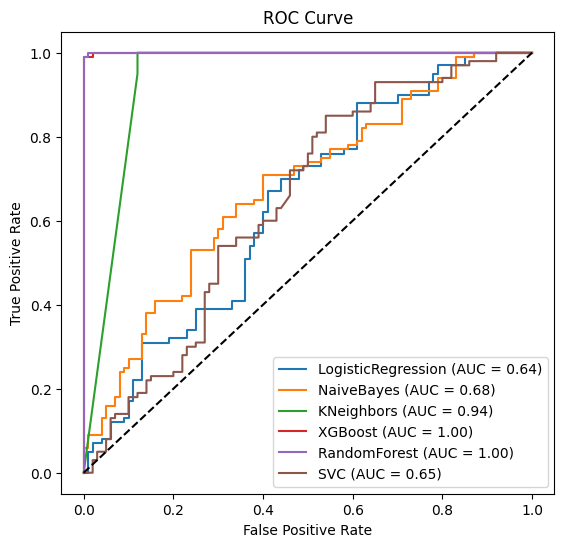

In [ ]:
# Plot ROC and PR curves
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for name, fpr, tpr, roc_auc in roc_curves:
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("roc.png", dpi=350)


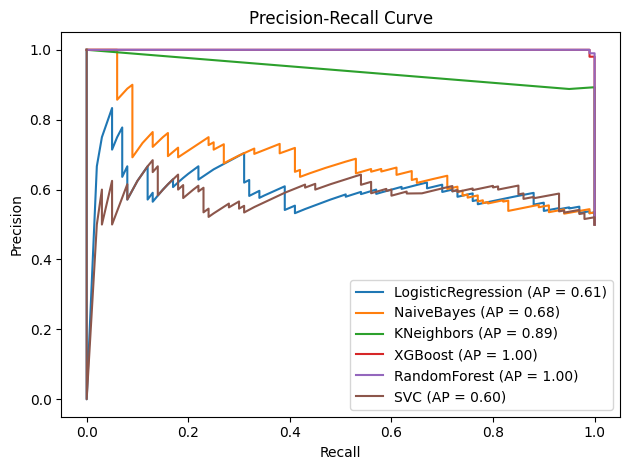

<Figure size 640x480 with 0 Axes>

In [ ]:
#plt.subplot(1, 2, 2)
for name, precision, recall, avg_precision in pr_curves:
    plt.plot(recall, precision, label=f"{name} (AP = {avg_precision:.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("pre-recall.png", dpi=350)



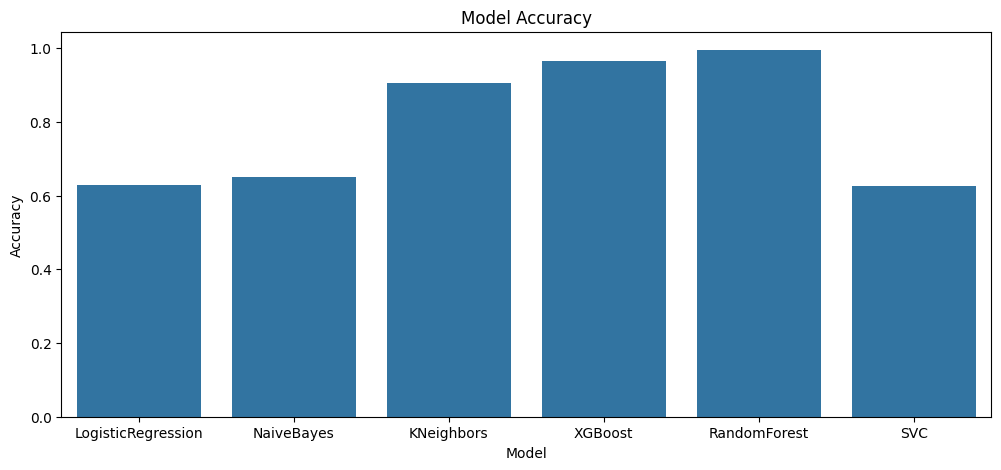

<Figure size 640x480 with 0 Axes>

In [ ]:
 # Accuracy comparison
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 5))
sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.title("Model Accuracy")
plt.show()
plt.savefig("accuracy.png", dpi=350)

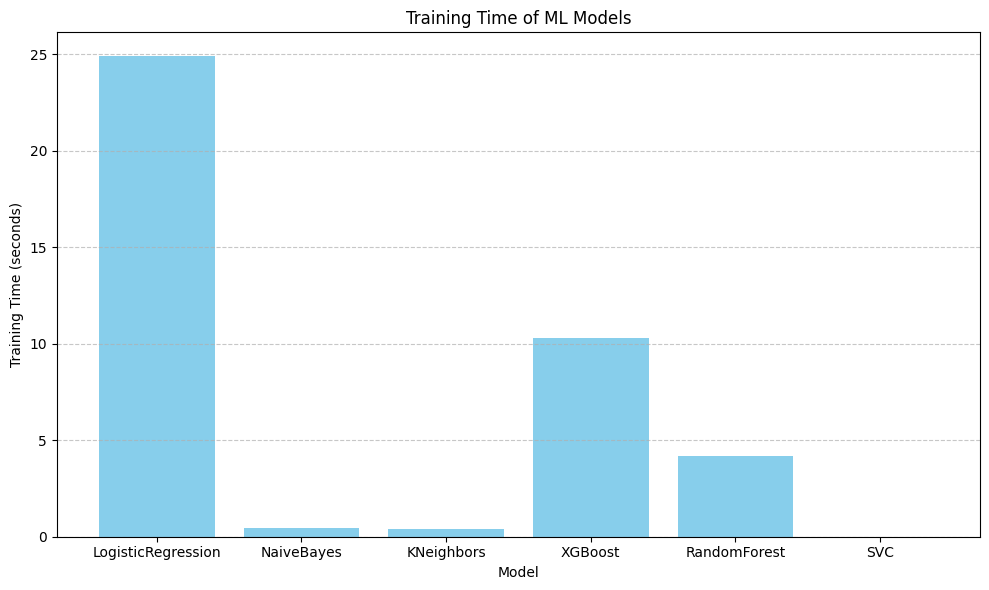

In [ ]:
import matplotlib.pyplot as plt

# Extract model names and training times from results
model_names_plot = [res["Model"] for res in results]
training_times = [res["Train Time (s)"] for res in results]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(model_names_plot, training_times, color='skyblue')
plt.xlabel("Model")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time of ML Models")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

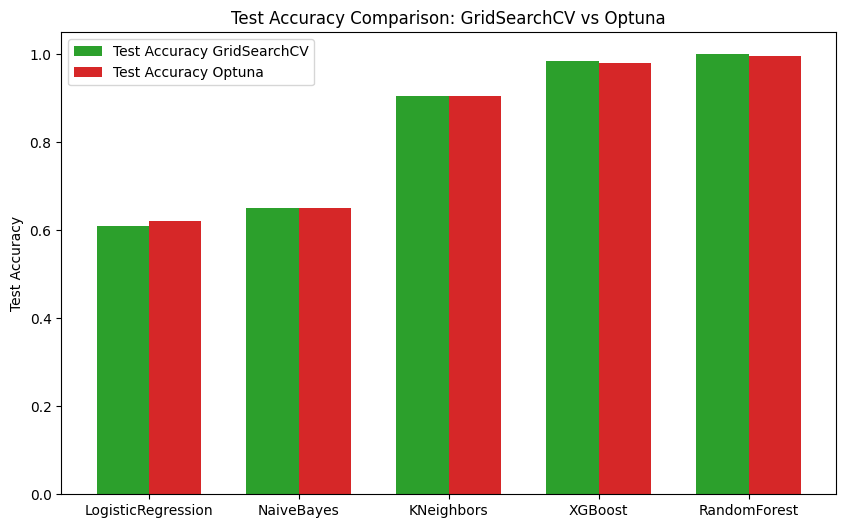

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['LogisticRegression', 'NaiveBayes', 'KNeighbors', 'XGBoost', 'RandomForest']

# Test Accuracy from GridSearchCV
accuracy_grid = [0.61, 0.65, 0.905, 0.985, 1.0]

# Test Accuracy from Optuna
accuracy_optuna = [0.62, 0.65, 0.905, 0.98, 0.995]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, accuracy_grid, width, label='Test Accuracy GridSearchCV', color='tab:green')
rects2 = ax.bar(x + width/2, accuracy_optuna, width, label='Test Accuracy Optuna', color='tab:red')

ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy Comparison: GridSearchCV vs Optuna')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1.05)

plt.show()